In [ ]:
#download PTB diagnostic ECG Database
#479
#https://www.physionet.org/content/ptbdb/1.0.0/
!wget -r -N -c -np https://physionet.org/files/ptbdb/1.0.0/

In [ ]:
#download the wfdb libraries and associated databases
#https://www.physionet.org/content/ptbdb/1.0.0/
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import posixpath

!pip install wfdb
import wfdb
from wfdb import processing
from PIL import Image 

In [3]:
#create new folder with only Patient_Samples
!mkdir /content/Patient_Samples
!mv /content/physionet.org/files/ptbdb/1.0.0/patient* /content/Patient_Samples/

In [ ]:
#get reason for admission and signal information for 1 second for the first channel and store in a numPy array
patient_path = sorted(os.listdir('/content/Patient_Samples/'))

#select channels, sampfrom, sampto parameters for training and testing
samples = [] #determine the order
classifications = [] #determine the classifiers
recordings = [] #collect the recordings
rec = [] #record for wfd library use
signal_im = [] #store signals

#obtain determine the relevant header files (hea)
#do not delete the other associated files .dat, .html, .xyz, .hea
for patient in patient_path:
  file_path = sorted(os.listdir('/content/Patient_Samples/' + patient))
  for filename in file_path:
    if filename.endswith('.hea'):
      #samples contains the actual file name in order
      samples.append(filename) #list which stores the actual filename
      #parameters can be modified
      signals, fields = wfdb.rdsamp('/content/Patient_Samples/'+patient+'/'+filename[:-4], channels=[4], sampfrom=6000, sampto=10000)
      #need to ensure the parameters are the same
      record = wfdb.rdrecord('/content/Patient_Samples/'+patient+'/'+filename[:-4], channels=[4], sampfrom=6000, sampto=10000) 
      #retrieving reason for admission
      diag = fields.get('comments')
      admit = diag[4]
      split_string = admit.split(': ', 1)
      classifications.append(split_string[1]) #list which stores the classifications
      recordings.append(record.p_signal[:,0]) #list of the recordings
      rec.append(record) #store the whole recording for wfdb plotting use
      
      #image generation
      plt.clf()
      plt.plot(record.p_signal[:,0])
      plt.axis('off')
      figure = plt.gcf()
      figure.set_size_inches(4, 2)
      plt.savefig("/content/sample.png", dpi=100, pad_inches=0, bbox_inches='tight')

      #store images in a list of numpy arrays
      img = Image.open('/content/sample.png') 
      numpydata = np.array(img)
      signal_im.append(numpydata) 

In [ ]:
#see classifications and signals for dataset specfied in range
for n in range(400,401):
  print(classifications[n])
  print(samples[n])
  print(recordings[n])
  plt.imshow(signal_im[n])
  wfdb.plot_wfdb(rec[n])

In [6]:
#split the data by myocardial infarction and healthy control
myocardial_class = []
myocardial_record = []
myocardial_image = []

healthy_class = []
healthy_record = []
healthy_image = []

for i in range(len(classifications)):

  #myocardial --> 0
  if classifications[i] == 'Myocardial infarction':
    myocardial_class.append(0)
    myocardial_record.append(recordings[i])
    myocardial_image.append(signal_im[i])

  #healthy --> 1
  if classifications[i] == 'Healthy control':
    healthy_class.append(1)
    healthy_record.append(recordings[i])
    healthy_image.append(signal_im[i])

class_names = ['Myocardial infarction', 'Healthy']

In [7]:
#convert from list to numpy array of #im, row, col
#images
myocardial_class = np.array(myocardial_class)
myocardial_imstack = np.stack(myocardial_image, axis=0)

healthy_class = np.array(healthy_class)
healthy_imstack = np.stack(healthy_image, axis=0)

#seperate the training and testing data for images

#train
train_class = np.concatenate((myocardial_class[:64], healthy_class[:64]), axis = 0)
train_image = np.concatenate((myocardial_imstack[:64,:,:,:], healthy_imstack[:64,:,:,:]), axis = 0)

#test
test_class = np.concatenate((myocardial_class[64:80], healthy_class[64:80]), axis = 0)
test_image = np.concatenate((myocardial_imstack[64:80,:,:,:], healthy_imstack[64:80,:,:,:]), axis = 0)

In [12]:
#importing tensorflow and libraries
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential

#helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [29]:
#data augmentation to avoid overfitting
#dropout may lead to inconsistency

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=np.shape(train_image[1]))
  ]
)

In [40]:
#https://www.tensorflow.org/tutorials/images/cnn
#define the neural network for image classification
num_classes = 2

model = Sequential([
  data_augmentation,
  #layers.Conv2D(32, (3, 3), activation='relu', input_shape=np.shape(train_image[1])),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [39]:
#clear the model
keras.backend.clear_session()

In [41]:
#summary of the model architecture
#https://www.tensorflow.org/tutorials/images/cnn
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 151, 310, 4)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 151, 310, 4)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 151, 310, 16)      592       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 155, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 155, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 77, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 77, 64)        1

In [42]:
#compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
#image classification training, can manipulate epochs
epochs = 10
history = model.fit(train_image, train_class, epochs=epochs, 
                    validation_data=(test_image, test_class), shuffle = True)

Epoch 1/10
4/4 [==============================] - 6s 2s/step - loss: 2.6325 - accuracy: 0.5031 - val_loss: 1.3506 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 6s 1s/step - loss: 0.8504 - accuracy: 0.6052 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 3/10
4/4 [==============================] - 6s 1s/step - loss: 0.7210 - accuracy: 0.4729 - val_loss: 0.6909 - val_accuracy: 0.5000
Epoch 4/10
4/4 [==============================] - 6s 1s/step - loss: 0.6794 - accuracy: 0.5437 - val_loss: 0.6512 - val_accuracy: 0.6875
Epoch 5/10
4/4 [==============================] - 6s 1s/step - loss: 0.6517 - accuracy: 0.6417 - val_loss: 0.6284 - val_accuracy: 0.6250
Epoch 6/10
4/4 [==============================] - 6s 1s/step - loss: 0.6165 - accuracy: 0.6729 - val_loss: 0.5969 - val_accuracy: 0.6875
Epoch 7/10
4/4 [==============================] - 6s 1s/step - loss: 0.6084 - accuracy: 0.6552 - val_loss: 0.5612 - val_accuracy: 0.6875
Epoch 8/10
4/4 [=========================

In [44]:
#evaluating the model for image classification
test_loss, test_acc = model.evaluate(test_image,  test_class, verbose=2) 
print('Test accuracy:', test_acc)

1/1 - 0s - loss: 0.5843 - accuracy: 0.6562
Test accuracy: 0.65625


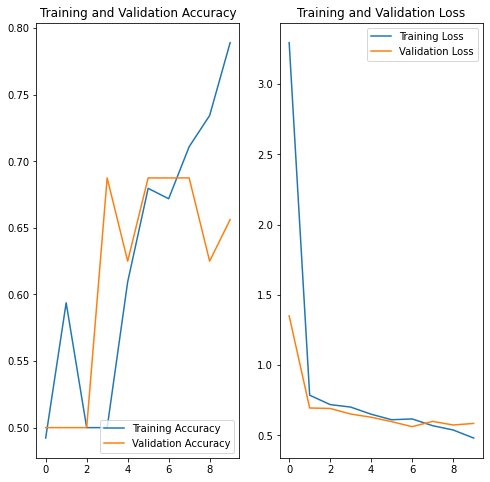

In [46]:
#evaluating the model for image classification
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#the prediction vs the actual for the test case for image classification
for n in range(0,32):
  print(n)
  predictions = model.predict(test_image)
  print('Neural Network Prediction: '+ class_names[np.argmax(predictions[n])])
  if test_class[n] == 0:
    print('Actual Condition: Myocardial infarction')
  if test_class[n] == 1:
    print('Actual Condition: Healthy')

In [ ]:
#10 epochs with shuffle on seems to be good got 75 and then 85 percent
#15 epochs with shuffle on seems to be good got 81 percent
#removing data augmentation got 78% and 71%

#models being generated are inconsistent